In [1]:
'''
AI / 機械学習 画像認識 人物判定 ver 1.0（今回作成した分についてはソースコードと実行結果のみです。）
readmeと一緒の内容です。

【見方】
判定結果はin4, 5の出力の箇所です。
今回は全画像使用パターンのみ出力しています。

【概要】
趣旨: 機械学習を用い、画像内の人物判定を行う。
元の画像枚数が7枚しかないので、NumPy Data Augmentationで画像データを水増ししています。

教師あり学習: k近傍法(k-NN)、サポートベクタマシン、ランダムフォレスト、グリッドサーチでそれぞれ試してみました。
教師なし学習: ついでにKMeansによるクラスタリングもやってみました。

今回行ったものの中ではランダムフォレスト, グリッドサーチバージョンが一番正解率が高めでした。
（元画像素材7枚 → 水増しからの機械学習予測正解率99%越え。増やしまくった甲斐があったんでしょうね。。。）

【詳細】
in1, 2で画像や.csv（教師データ）の処理、
in3で学習させるためのデータ（画像から作ったヒストグラムを特徴量に使用）の処理、
in4で学習 → 予測させ判定、in5は正解率の一覧です。
それ以降は他のアルゴリズムで作ったソースです。

交差検証の回数を増やすとPCが悲鳴をあげていました笑
回帰や次元削減、グラフ描画、他アルゴリズム等、ちょうどいいテーマが見つかり次第、また新しく作ります。

作成日: 2021/7/25, 作成者: Y.T（nazuna2371）
画像引用元（所属会社）ホームページ: https://toyo-integration.co.jp/
'''


# ↓ 途中までは共用 ↓


switch = 0 # 0で全画像を使用、1でグレー画像のみ使用、2でいくつか削ったもの、以外はgrayscale画像などを作成


import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

%matplotlib inline


# NumPy Data Augmentation用関数
# Horizontal Flip
def horizontal_flip(image, rate = 1):
    if np.random.rand() < rate:
        image = image[:, ::-1, :]
    return image

# Vertical Flip
def vertical_flip(image, rate = 1):
    if np.random.rand() < rate:
        image = image[::-1, :, :]
    return image

# Random Rotation
from scipy.ndimage.interpolation import rotate
def random_rotation(image, angle_range = (0, 180)):
    h, w, _ = image.shape
    angle = np.random.randint(*angle_range)
    image = rotate(image, angle)
#    image = imresize(image, (h, w))
    return image

元画像の枚数: 7
.csvの中身（教師データ内訳）: 
    id  person1  person2  person3  person4  person5  person6  person7  \
0    0        1        0        0        0        0        0        0   
1    1        1        0        0        0        0        0        0   
2    2        1        0        0        0        0        0        0   
3    3        1        0        0        0        0        0        0   
4    4        1        0        0        0        0        0        0   
..  ..      ...      ...      ...      ...      ...      ...      ...   
79  79        1        1        1        1        0        0        0   
80  80        1        1        1        1        0        0        0   
81  81        1        1        1        1        0        0        0   
82  82        1        1        1        1        0        0        0   
83  83        1        1        1        1        0        0        0   

    person8  person9  
0         0        0  
1         0        0  
2         0        0  
3 

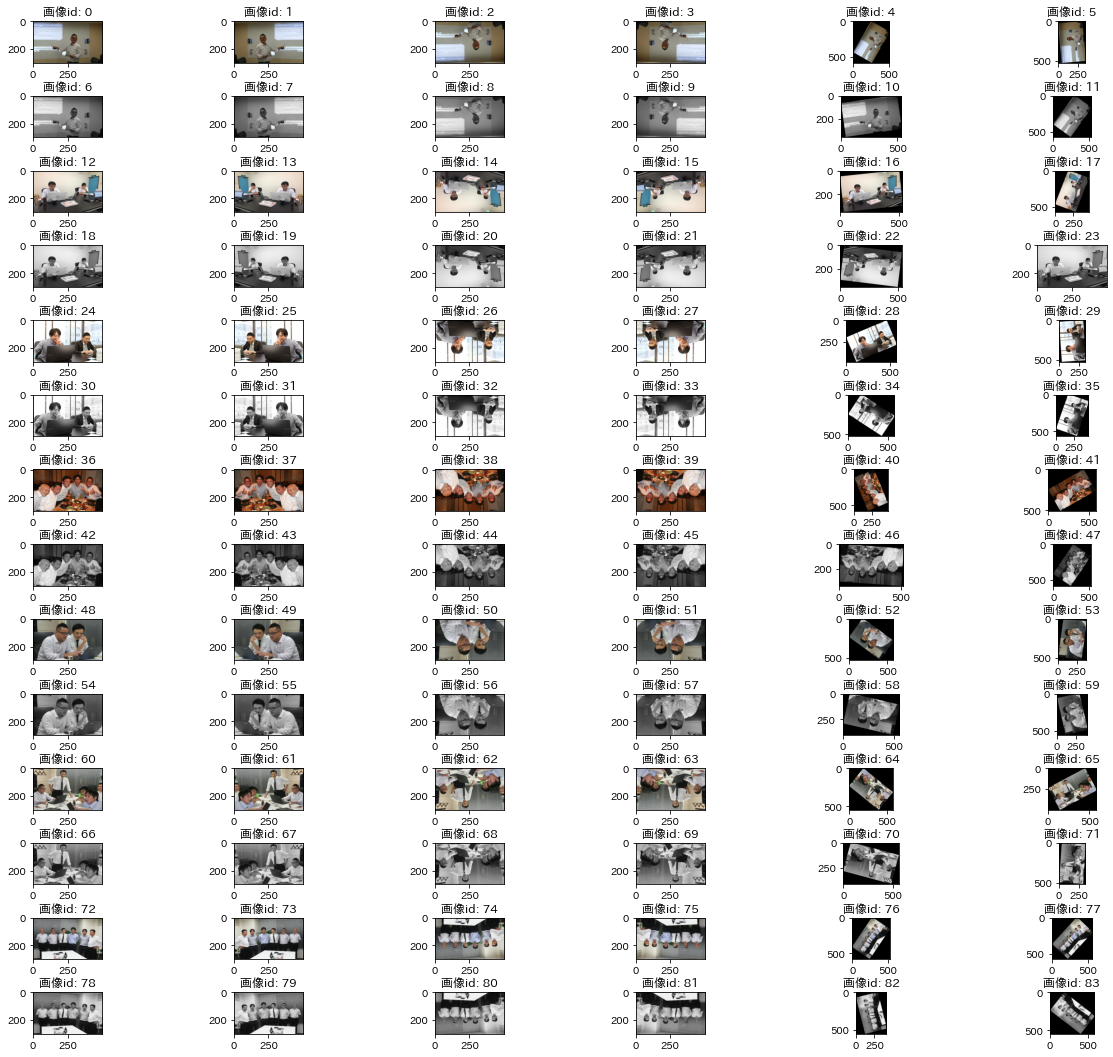

In [2]:
# 教師データ.csv読み込み
file_name = ""
csv_rows_num = 0
if switch == 0:
    file_name = "./images/member_classified.csv" # 全画像ver
    csv_rows_num = 7
elif switch == 1:
    file_name = "./images/member_classified_gray.csv" # グレーのみver
    csv_rows_num = sum([1 for _ in open(file_name)]) // 6
elif switch == 2:
    file_name = "./images/member_classified_shaved.csv" # いくつか削ったver
    csv_rows_num = sum([1 for _ in open(file_name)]) // 4

targets_data = pd.read_csv(file_name)

print("元画像の枚数: " + str(csv_rows_num))
print(".csvの中身（教師データ内訳）: ")
print(targets_data)


# 登場人物のリスト
target_person = [value for value in targets_data]
target_person = target_person[1:]
print("登場人物のリスト: " + str(target_person))


# 機械学習での判定に使う画像を加工しながら配列に格納
# 元の画像材料が7枚のみ。84枚に水増し
img_list = []
for i in range(csv_rows_num):
    if switch == 0:
        target_img = Image.open("./images/%03d.jpg" % (i))
        target_img = target_img.resize((500, 300))

        img_list.append(np.array(target_img))
        img_list.append(horizontal_flip(np.array(target_img)))
        img_list.append(vertical_flip(np.array(target_img)))    
        img_list.append(horizontal_flip(vertical_flip(np.array(target_img))))
        img_list.append(random_rotation(np.array(target_img)))
        img_list.append(random_rotation(np.array(target_img)))

        # ついでにグレースケールの画像も追加
        target_img = Image.open("./images/gray%03d.jpg" % (i))
        target_img = cv2.imread("./images/gray%03d.jpg" % (i), cv2.IMREAD_GRAYSCALE)
        target_img = cv2.resize(target_img, (500, 300))
        target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB) # BGR → RGBに変換
        img_list.append(np.array(target_img))
        
        # 追加分 グレースケール画像加工
        img_list.append(horizontal_flip(np.array(target_img)))
        img_list.append(vertical_flip(np.array(target_img)))    
        img_list.append(horizontal_flip(vertical_flip(np.array(target_img))))
        img_list.append(random_rotation(np.array(target_img)))
        img_list.append(random_rotation(np.array(target_img)))
        
    elif switch == 1:
        target_img = cv2.imread("./images/%03d.jpg" % (i), cv2.IMREAD_GRAYSCALE)
        target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB) # BGR → RGBに変換
        target_img = cv2.resize(target_img, (500, 300))

        img_list.append(target_img)
        img_list.append(horizontal_flip(target_img))
        img_list.append(vertical_flip(target_img))    
        img_list.append(horizontal_flip(target_img))
        img_list.append(random_rotation(target_img))
        img_list.append(random_rotation(target_img))

    elif switch == 2:
        target_img = Image.open("./images/%03d.jpg" % (i))
        target_img = target_img.resize((500, 300))

        img_list.append(np.array(target_img))
        img_list.append(horizontal_flip(np.array(target_img)))
        img_list.append(vertical_flip(np.array(target_img)))    
        img_list.append(horizontal_flip(vertical_flip(np.array(target_img))))

    else:
#        グレースケール画像などを作成するためのもの
        jpg = "./images/%03d.jpg" % (i)
        img = cv2.imread(jpg, cv2.IMREAD_GRAYSCALE)
        cv2.imwrite("./images/gray%03d.jpg" % (i), img)
        img = cv2.imread(jpg, cv2.IMREAD_UNCHANGED)
        cv2.imwrite("./images/rgba%03d.jpg" % (i), img)    

print("Augmentationで水増し処理後の画像の合計枚数: " + str(len(img_list)))

# 配列に格納した画像をサブプロットで描画し確認
def img__show_adj(w_size = 20, hsize = 15, w_num = 7, w_space = 0, h_space = 0):
    img_plot_fig = plt.figure(figsize = (w_size, w_size))
    for i in range(len(img_list)):
        img_plot = img_plot_fig.add_subplot((len(img_list) // w_num) + 1, w_num, i + 1)
        img_plot.set_title("画像id: " + str(i))
        plt.subplots_adjust(wspace = w_space, hspace = h_space)
        img_plot.imshow(img_list[i])

if switch == 0:
    img__show_adj(20, 20, 6, 0.8, 0.8)
elif switch == 1:
    img__show_adj(20, 20, 6, 0.4, 0.4)
elif switch == 2:
    img__show_adj(20, 20, 4, 0.4, 0.4)

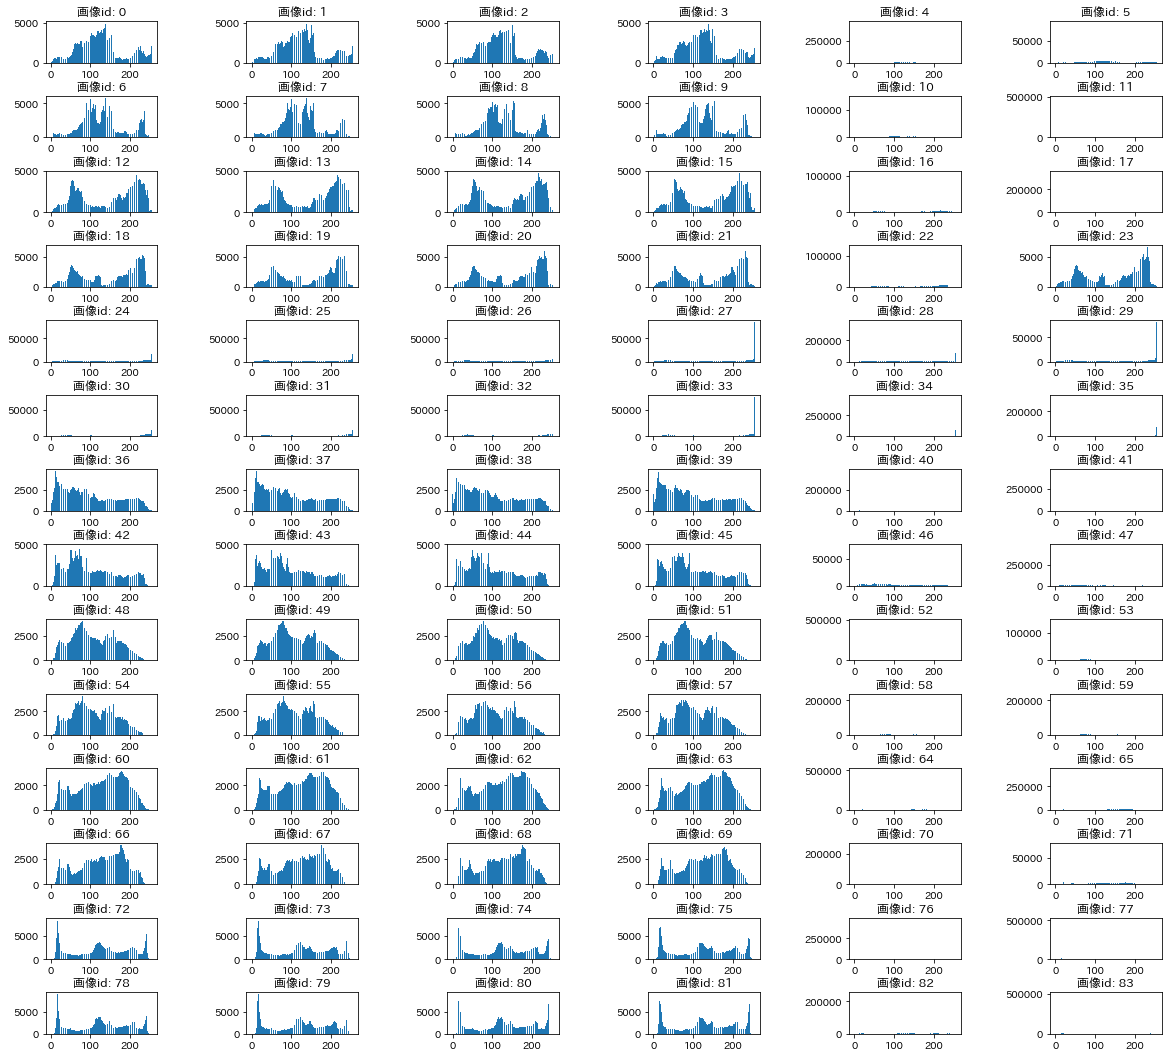

In [3]:
images_data = np.empty((0, 256), int)
# print(images_data.shape)

# ヒストグラムを特徴量として使用するため、配列に格納
for img in img_list:
    hist = np.histogram(img.ravel(), 256, [0, 256])
    img_hist = hist[0]
    images_data = np.append(images_data, np.array([hist[0]]), axis = 0)

    
# ヒストグラムを描画し確認
def plot_hist(w_size = 20, hsize = 15, w_num = 7, w_space = 0, h_space = 0):
    hist_plot_fig = plt.figure(figsize = (w_size, w_size))
    for i, img_hist in enumerate(images_data):
        hist_plot = hist_plot_fig.add_subplot((len(img_list) // w_num) + 1, w_num, i + 1)
        hist_plot.set_title("画像id: " + str(i))
        hist_plot.bar(np.arange(256), img_hist)
    else:
        plt.subplots_adjust(wspace = w_space, hspace = h_space)
        plt.show()

if switch == 0:
    plot_hist(20, 20, 6, 0.8, 0.8)
elif switch == 1:
    plot_hist(20, 20, 6, 0.4, 0.4)
elif switch == 2:
    plot_hist(20, 20, 4, 0.4, 0.4)
    

# jupyter Nootbook上で結果の表示を分けたかったため、各学習について一度それぞれを配列に格納し後から描画
check_list_1 = []
check_list_2 = []

# ↑ ここまでは共用 ↑

In [4]:
# ランダムフォレスト, グリッドサーチバージョン

'''
現状の結果
学習の種類: 教師あり学習
使用分類アルゴリズム: ランダムフォレスト, グリッドサーチ
seed値固定せずのランダム仕様

【結果】
テストデータ（画像） 21枚に対しての

person1さんの機械学習の判定正解率: 1.0
person2さんの機械学習の判定正解率: 1.0
person3さんの機械学習の判定正解率: 1.0
person4さんの機械学習の判定正解率: 1.0
person5さんの機械学習の判定正解率: 1.0
person6さんの機械学習の判定正解率: 1.0
person7さんの機械学習の判定正解率: 1.0
person8さんの機械学習の判定正解率: 0.9523809523809523
person9さんの機械学習の判定正解率: 1.0

全体の平均正解率: 0.9947089947089948
'''

from sklearn.ensemble import RandomForestClassifier

# 学習 → 予測をさせ、結果を各配列に格納
for i, name in enumerate(target_person):
    print(name + "さん: ")

    X_train, X_test, y_train, y_test = train_test_split(images_data, targets_data[name])

    # ランダムフォレスト、グリッドサーチを使用
    param = {'n_estimators': np.arange(1, 150)}
    grid_search = GridSearchCV(RandomForestClassifier(), param, cv = 5, verbose = 3, n_jobs = -1, refit = True) # cv = 5

    grid_search.fit(X_train,y_train)
    y_predict = grid_search.predict(X_test)

    if i == 0:
        check_list_2.append("テストデータ（画像） {}枚に対しての".format(str(len(X_test))))
    check_list_2.append(["{}さんの機械学習の判定正解率: ".format(target_person[i]), np.mean(y_predict == y_test)])

    for v, [j, k] in enumerate(y_test.items()): # 実際の正解と機械学習の判別値, 1 = いる 0 = いない
        print("index: ", v, " 画像id: ", j, " 正解: ", k, " 予測: ", y_predict[v])
    
    print("正解率: ", np.mean(y_predict == y_test), "\n")

    # classification_reportの表示
    # precision = 適合率, recall = 再現率, f1-score = F値（適合率と再現率の調和平均、バランス）, support = データ数
    print(classification_report(y_test, y_predict))

person1さん: 
Fitting 5 folds for each of 149 candidates, totalling 745 fits
index:  0  画像id:  80  正解:  1  予測:  1
index:  1  画像id:  62  正解:  1  予測:  1
index:  2  画像id:  33  正解:  0  予測:  0
index:  3  画像id:  73  正解:  1  予測:  1
index:  4  画像id:  58  正解:  1  予測:  1
index:  5  画像id:  28  正解:  0  予測:  0
index:  6  画像id:  30  正解:  0  予測:  0
index:  7  画像id:  20  正解:  0  予測:  0
index:  8  画像id:  59  正解:  1  予測:  1
index:  9  画像id:  27  正解:  0  予測:  0
index:  10  画像id:  31  正解:  0  予測:  0
index:  11  画像id:  79  正解:  1  予測:  1
index:  12  画像id:  15  正解:  0  予測:  0
index:  13  画像id:  71  正解:  1  予測:  1
index:  14  画像id:  66  正解:  1  予測:  1
index:  15  画像id:  11  正解:  1  予測:  1
index:  16  画像id:  50  正解:  1  予測:  1
index:  17  画像id:  14  正解:  0  予測:  0
index:  18  画像id:  41  正解:  1  予測:  1
index:  19  画像id:  48  正解:  1  予測:  1
index:  20  画像id:  42  正解:  1  予測:  1
正解率:  1.0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1    

index:  0  画像id:  81  正解:  1  予測:  1
index:  1  画像id:  44  正解:  1  予測:  1
index:  2  画像id:  71  正解:  1  予測:  1
index:  3  画像id:  72  正解:  1  予測:  1
index:  4  画像id:  48  正解:  0  予測:  0
index:  5  画像id:  31  正解:  0  予測:  0
index:  6  画像id:  51  正解:  0  予測:  0
index:  7  画像id:  20  正解:  0  予測:  0
index:  8  画像id:  3  正解:  0  予測:  0
index:  9  画像id:  24  正解:  0  予測:  0
index:  10  画像id:  29  正解:  0  予測:  0
index:  11  画像id:  26  正解:  0  予測:  0
index:  12  画像id:  10  正解:  0  予測:  0
index:  13  画像id:  47  正解:  1  予測:  0
index:  14  画像id:  28  正解:  0  予測:  0
index:  15  画像id:  6  正解:  0  予測:  0
index:  16  画像id:  63  正解:  1  予測:  1
index:  17  画像id:  38  正解:  1  予測:  1
index:  18  画像id:  66  正解:  1  予測:  1
index:  19  画像id:  30  正解:  0  予測:  0
index:  20  画像id:  45  正解:  1  予測:  1
正解率:  0.9523809523809523 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.89      0.94         9

    accuracy           

In [5]:
# 全員分の判定正解率
mean_list = []
for i, line in enumerate(check_list_2):
    if i == 0:
        print(line + "\n")
    else:
        print(line[0] + str(line[1]))
        mean_list.append(line[1])

print("\n全体の平均正解率: " + str(np.mean(mean_list)))

テストデータ（画像） 21枚に対しての

person1さんの機械学習の判定正解率: 1.0
person2さんの機械学習の判定正解率: 1.0
person3さんの機械学習の判定正解率: 1.0
person4さんの機械学習の判定正解率: 1.0
person5さんの機械学習の判定正解率: 1.0
person6さんの機械学習の判定正解率: 1.0
person7さんの機械学習の判定正解率: 1.0
person8さんの機械学習の判定正解率: 0.9523809523809523
person9さんの機械学習の判定正解率: 1.0

全体の平均正解率: 0.9947089947089948


# 以下は他アルゴリズムなど

In [ ]:
# k近傍法(k-NN)のみバージョン

'''
現状の結果
学習の種類: 教師あり学習
使用分類アルゴリズム: k近傍法(k-nearest neighbor algorithm, k-NN)
seed値固定せずのランダム仕様

【結果】
テストデータ（画像） 26枚に対しての

person1さんの機械学習の判定正解率: 0.8461538461538461
person2さんの機械学習の判定正解率: 0.8846153846153846
person3さんの機械学習の判定正解率: 0.8076923076923077
person4さんの機械学習の判定正解率: 0.8846153846153846
person5さんの機械学習の判定正解率: 1.0
person6さんの機械学習の判定正解率: 0.9615384615384616
person7さんの機械学習の判定正解率: 0.8846153846153846
person8さんの機械学習の判定正解率: 0.8076923076923077
person9さんの機械学習の判定正解率: 0.9230769230769231

全体の平均正解率: 0.8888888888888888
'''

from sklearn.neighbors import KNeighborsClassifier

# 学習 → 予測をさせ、結果を各配列に格納
for i, name in enumerate(target_person):
    print(name + "さん: ")

#    X_train, X_test, y_train, y_test = train_test_split(images_data, targets_data[name], test_size = 0.5, random_state = 123)
    X_train, X_test, y_train, y_test = train_test_split(images_data, targets_data[name], test_size = 0.3)

    check_list_1.append(X_train)
    check_list_1.append(X_test)
    check_list_1.append(y_train)
    check_list_1.append(y_test)

    # 分類アルゴリズムはk近傍法を使用
    kncf = KNeighborsClassifier(n_neighbors = 1)
    kncf.fit(X_train, y_train)
    
    y_predict = kncf.predict(X_test)

    if i == 0:
        check_list_2.append("テストデータ（画像） {}枚に対しての".format(str(len(X_test))))
    check_list_2.append(["{}さんの機械学習の判定正解率: ".format(target_person[i]), np.mean(y_predict == y_test)])

    for v, [j, k] in enumerate(y_test.items()): # 実際の正解と機械学習の判別値, 1 = いる 0 = いない
#        pass
        print("index: ", v, " 画像id: ", j, " 正解: ", k, " 予測: ", y_predict[v])
    
    print("正解率: ", np.mean(y_predict == y_test), "\n")
    
#        print(targets_data[j: j + 1])

    # classification_reportの表示
    # precision = 適合率, recall = 再現率, f1-score = F値（適合率と再現率の調和平均、バランス）, support = データ数
    print(classification_report(y_test, y_predict))

In [ ]:
print(check_list_1[0].shape)
print(check_list_1[1].shape)
print(check_list_1[2].shape)
print(check_list_1[3].shape)

In [ ]:
# k近傍法(k-NN) & グリッドサーチバージョン

'''
現状の結果
学習の種類: 教師あり学習
使用分類アルゴリズム: k近傍法(k-nearest neighbor algorithm, k-NN)、グリッドサーチ
seed値固定せずのランダム仕様

【結果】
テストデータ（画像） 26枚に対しての

person1さんの機械学習の判定正解率: 0.9615384615384616
person2さんの機械学習の判定正解率: 0.9230769230769231
person3さんの機械学習の判定正解率: 0.9230769230769231
person4さんの機械学習の判定正解率: 0.9615384615384616
person5さんの機械学習の判定正解率: 1.0
person6さんの機械学習の判定正解率: 0.9615384615384616
person7さんの機械学習の判定正解率: 1.0
person8さんの機械学習の判定正解率: 0.8846153846153846
person9さんの機械学習の判定正解率: 0.8846153846153846

全体の平均正解率: 0.9444444444444444
'''

from sklearn.neighbors import KNeighborsClassifier

# 学習 → 予測をさせ、結果を各配列に格納
for i, name in enumerate(target_person):
    print(name + "さん: ")

#    X_train, X_test, y_train, y_test = train_test_split(images_data, targets_data[name], test_size = 0.5, random_state = 123)
    X_train, X_test, y_train, y_test = train_test_split(images_data, targets_data[name], test_size = 0.3)
    
    # k近傍法 & グリッドサーチを使用
    params = {"n_neighbors": np.arange(1, 11)}

    clf = GridSearchCV(KNeighborsClassifier(), params, cv = 10, return_train_score = False)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)

    if i == 0:
        check_list_2.append("テストデータ（画像） {}枚に対しての".format(str(len(X_test))))
    check_list_2.append(["{}さんの機械学習の判定正解率: ".format(target_person[i]), np.mean(y_predict == y_test)])

    for v, [j, k] in enumerate(y_test.items()): # 実際の正解と機械学習の判別値, 1 = いる 0 = いない
#        pass
        print("index: ", v, " 画像id: ", j, " 正解: ", k, " 予測: ", y_predict[v])
    
    print("正解率: ", np.mean(y_predict == y_test), "\n")
    
#        print(targets_data[j: j + 1])

    # classification_reportの表示
    # precision = 適合率, recall = 再現率, f1-score = F値（適合率と再現率の調和平均、バランス）, support = データ数
    print(classification_report(y_test, y_predict))
    
''' k値のscore確認用
    best_clf = clf.best_estimator_
    best_score = best_clf.score(X_test, y_test)
    print(f"score: {best_score:.2%}")  # score: 100.00%

    cv_result = pd.DataFrame(clf.cv_results_)
    for row in cv_result.itertuples():
        print(f"k = {row.params['n_neighbors']}: {row.mean_test_score:.2%}")
'''

In [ ]:
# サポートベクタマシンのみバージョン。画像データのグラフ化は一旦断念

'''
現状の結果
学習の種類: 教師あり学習
使用分類アルゴリズム: サポートベクタマシン
seed値固定せずのランダム仕様

【結果】
テストデータ（画像） 21枚に対しての

person1さんの機械学習の判定正解率: 0.7619047619047619
person2さんの機械学習の判定正解率: 0.9047619047619048
person3さんの機械学習の判定正解率: 0.8095238095238095
person4さんの機械学習の判定正解率: 1.0
person5さんの機械学習の判定正解率: 0.9523809523809523
person6さんの機械学習の判定正解率: 0.9523809523809523
person7さんの機械学習の判定正解率: 0.8571428571428571
person8さんの機械学習の判定正解率: 0.7619047619047619
person9さんの機械学習の判定正解率: 0.9523809523809523

全体の平均正解率: 0.8835978835978836
'''

from sklearn import svm

# 学習 → 予測をさせ、結果を各配列に格納
for i, name in enumerate(target_person):
    print(name + "さん: ")

    X_train, X_test, y_train, y_test = train_test_split(images_data, targets_data[name])

    # サポートベクタマシンを使用
#    clf = svm.SVC(gamma = 0.0001, C = 10, kernel = "linear")
    clf = svm.SVC(gamma = 0.0001, C = 1)

    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)


    if i == 0:
        check_list_2.append("テストデータ（画像） {}枚に対しての".format(str(len(X_test))))
    check_list_2.append(["{}さんの機械学習の判定正解率: ".format(target_person[i]), np.mean(y_predict == y_test)])

    for v, [j, k] in enumerate(y_test.items()): # 実際の正解と機械学習の判別値, 1 = いる 0 = いない
#        pass
        print("index: ", v, " 画像id: ", j, " 正解: ", k, " 予測: ", y_predict[v])
    
    print("正解率: ", np.mean(y_predict == y_test), "\n")

    # classification_reportの表示
    # precision = 適合率, recall = 再現率, f1-score = F値（適合率と再現率の調和平均、バランス）, support = データ数
    print(classification_report(y_test, y_predict))

In [ ]:
# サポートベクタマシン % グリッドサーチバージョン

'''
現状の結果
学習の種類: 教師あり学習
使用分類アルゴリズム: サポートベクタマシン、グリッドサーチ
seed値固定せずのランダム仕様

【結果】
テストデータ（画像） 21枚に対しての

person1さんの機械学習の判定正解率: 0.9523809523809523
person2さんの機械学習の判定正解率: 0.9523809523809523
person3さんの機械学習の判定正解率: 0.8571428571428571
person4さんの機械学習の判定正解率: 0.9047619047619048
person5さんの機械学習の判定正解率: 1.0
person6さんの機械学習の判定正解率: 1.0
person7さんの機械学習の判定正解率: 0.9047619047619048
person8さんの機械学習の判定正解率: 0.7142857142857143
person9さんの機械学習の判定正解率: 0.9523809523809523

全体の平均正解率: 0.9153439153439152
'''

from sklearn import svm

# 学習 → 予測をさせ、結果を各配列に格納
for i, name in enumerate(target_person):
    print(name + "さん: ")

    X_train, X_test, y_train, y_test = train_test_split(images_data, targets_data[name])

    # サポートベクタマシン、グリッドサーチを使用

    param_grid = {}
    clf = GridSearchCV(svm.SVC(C = 1, gamma = 0.0001, kernel = "rbf"), param_grid, refit = True, verbose = 3, cv = 10)

    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)


    if i == 0:
        check_list_2.append("テストデータ（画像） {}枚に対しての".format(str(len(X_test))))
    check_list_2.append(["{}さんの機械学習の判定正解率: ".format(target_person[i]), np.mean(y_predict == y_test)])

    for v, [j, k] in enumerate(y_test.items()): # 実際の正解と機械学習の判別値, 1 = いる 0 = いない
#        pass
        print("index: ", v, " 画像id: ", j, " 正解: ", k, " 予測: ", y_predict[v])
    
    print("正解率: ", np.mean(y_predict == y_test), "\n")

    # classification_reportの表示
    # precision = 適合率, recall = 再現率, f1-score = F値（適合率と再現率の調和平均、バランス）, support = データ数
    print(classification_report(y_test, y_predict))

In [ ]:
# 全員分の判定正解率
mean_list = []
for i, line in enumerate(check_list_2):
    if i == 0:
        print(line + "\n")
    else:
        print(line[0] + str(line[1]))
        mean_list.append(line[1])

print("\n全体の平均正解率: " + str(np.mean(mean_list)))

In [ ]:
# 教師なし学習、KMeansでのクラスタリング。無理やりやってみました。

'''
現状の結果
学習の種類: 教師なし学習
使用分類アルゴリズム: KMeans

【結果】
テストデータ（画像） 84枚に対しての
person1さんの機械学習の判定正解率: 0.6071428571428571
person2さんの機械学習の判定正解率: 0.6071428571428571
person3さんの機械学習の判定正解率: 0.5357142857142857
person4さんの機械学習の判定正解率: 0.6071428571428571
person5さんの機械学習の判定正解率: 0.6785714285714286
person6さんの機械学習の判定正解率: 0.6547619047619048
person7さんの機械学習の判定正解率: 0.34523809523809523
person8さんの機械学習の判定正解率: 0.4642857142857143
person9さんの機械学習の判定正解率: 0.4166666666666667

全体の平均正解率: 0.5462962962962963
'''

from sklearn.cluster import KMeans

check_list_2.clear()

# 学習 → 予測をさせ、結果を各配列に格納
for i, name in enumerate(target_person):
    print(name + "さん: ")
        
    # 教師なし学習、KMeansでのクラスタリング
    k_means = KMeans(n_clusters = 2)
    k_means_pred = k_means.fit_predict(images_data)

#    print(k_means.labels_)
#    print(k_means.cluster_centers_)
    
    train_array = [k[1] for j, k in enumerate(targets_data.loc[:, name].items())]

    check_list_2.append(["{}さんの機械学習の判定正解率: ".format(target_person[i]), np.mean(k_means_pred == train_array)])

    for j, line in enumerate(train_array):
        print("index: ", j, " 正解: ", line, " 予測: ", k_means_pred[j])

    # 実際の正解と機械学習の判別値, 1 = いる 0 = いない    
    print("正解率: ", np.mean(k_means_pred == targets_data.loc[:, name]), "\n")

In [ ]:
# 全員分の判定正解率
print("テストデータ（画像） {}枚に対しての".format(str(len(train_array))))

mean_list = []
for line in check_list_2:
    print(line[0] + str(line[1]))
    mean_list.append(line[1])

print("\n全体の平均正解率: " + str(np.mean(mean_list)))